In [14]:
%matplotlib notebook
import os, sys, inspect, warnings
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
main_dir = '/'.join(curr_dir.split('/')[:-1])
sub_dir = os.path.join(main_dir, 'RGCPD/')
# core_pp = os.path.join(main_dir, 'RGCPD/core')
if main_dir not in sys.path:
    sys.path.append(main_dir)
    sys.path.append(sub_dir)
import numpy as np
import math
from collections import Counter
# import statsmodels.api as sm 
import pandas as pd 
import math
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import itertools as it
import pywt as wv
from scipy.fftpack import fft
from copy import deepcopy
# from statsmodels.tsa.arima_process import  arma_generate_sample, ArmaProcess
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from pprint import pprint as pp 
from pandas.plotting import register_matplotlib_converters
from RGCPD import RGCPD
from RGCPD import BivariateMI
from df_ana_class import DataFrameAnalysis, VisualizeAnalysis
import core_pp
import plot_signal_decomp
import plot_coeffs
from visualize_cwt import *
import wave_ana as wa 
import synthetic_data as synth 
register_matplotlib_converters()
np.random.seed(12345)
plt.style.use('seaborn')

In [15]:
path_data = os.path.join(main_dir, 'data')
current_analysis_path = os.path.join(main_dir, 'Jier_analysis')
target= 3
target_path = os.path.join(path_data, 'tf5_nc5_dendo_80d77.nc')
precursor_path = os.path.join(path_data,'sst_1979-2018_2.5deg_Pacific.nc')
list_of_name_path = [(target, target_path), 
                    ('sst', precursor_path )]
list_for_MI = [BivariateMI(name='sst', func=BivariateMI.corr_map, 
                          kwrgs_func={'alpha':.0001, 'FDR_control':True}, 
                          distance_eps=700, min_area_in_degrees2=5)]
rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           start_end_TVdate=('06-01', '08-31'),
           path_outmain=os.path.join(main_dir,'data'))
rg.pp_precursors(detrend=True, anomaly=True, selbox=None)
rg.pp_TV()
rg.traintest(method='no_train_test_split')
rg.calc_corr_maps()
rg.cluster_list_MI()
rg.get_ts_prec(precur_aggr=1)
rg.PCMCI_df_data(tau_max=2)
rg.PCMCI_get_links()
rg.df_MCIc
rg.PCMCI_plot_graph()

Loaded pre-processed data of sst

original tfreq of imported response variable is converted to desired tfreq 10
Daily input freq
No train test split

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(400dp, 100%)

redefine target variable on 1 day means
Selecting subset as defined by start_end_date
Daily input freq
No train test split

Getting MI timeseries
There are [2] regions in total (list of different splits)
Progress causal inference - traintest set 100%

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

In [16]:
rg_data  = rg.df_data[['3ts', '0..1..sst', '0..2..sst']]


In [17]:
rg_data.head()

3ts  0..1..sst  0..2..sst
0 1979-01-01  -2.664228   0.494538  -0.068472
  1979-01-02  -9.341890   0.431183  -0.044069
  1979-01-03 -11.166506   0.318882   0.032424
  1979-01-04  -9.356115   0.162380   0.097497
  1979-01-05 -10.433442   0.043910   0.135536

In [18]:

rg_index = rg_data.index.levels[1]
prec1 = rg_data.iloc[:,1].values
prec2 = rg_data.iloc[:,2].values
target = rg_data.iloc[:,0].values
# wave  = wv.Wavelet('sym8')
# mode=wv.Modes.periodic

In [19]:
def visualise_data(df):
    fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
    colors=['red', 'green', 'blue']
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]].values
        ax.plot(df.index.levels[1], data, color=colors[i], linewidth=1)
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

    plt.tight_layout();

In [20]:
visualise_data(rg_data)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

In [21]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [22]:
grangers_causation_matrix(rg_data,variables=rg_data.columns.tolist() )

,3ts_x,0..1..sst_x,0..2..sst_x
3ts_y,1.0000,0.0,0.0
0..1..sst_y,0.0029,1.0,0.0
0..2..sst_y,0.0000,0.0,1.0


In [23]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [24]:
cointegration_test(rg_data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
3ts    ::  1476.62   > 24.2761   =>   True
0..1..sst ::  258.55    > 12.3212   =>   True
0..2..sst ::  67.41     > 4.1296    =>   True


In [26]:
%matplotlib notebook
pd.plotting.lag_plot(rg_data.iloc[:,0], lag=2)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

In [27]:
m = VAR(rg_data)

/home/jier/miniconda3/envs/RGCPD/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [28]:
result = m.fit(2)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 24, Sep, 2020
Time:                     11:15:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -9.60222
Nobs:                     14598.0    HQIC:                  -9.60951
Log likelihood:           8046.28    FPE:                6.68449e-05
AIC:                     -9.61314    Det(Omega_mle):     6.67488e-05
--------------------------------------------------------------------
Results for equation 3ts
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.000858         0.018777            0.046           0.964
L1.3ts               1.103167         0.007757          142.207           0.000
L1.0..1..sst         0.851111         0.188626            4.512   

In [29]:
result.bic

-9.602219160056732

In [30]:
result.plotsim()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

In [31]:
result.plot_acorr()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

In [32]:
result.plot_forecast(steps=10)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

In [14]:
m.select_order(3, trend='ct')

In [15]:
r_select = m.fit(maxlags=3, ic='aic')

In [16]:
r_select.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 15, Sep, 2020
Time:                     17:21:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -9.64906
Nobs:                     14597.0    HQIC:                  -9.65948
Log likelihood:           8430.79    FPE:                6.34879e-05
AIC:                     -9.66466    Det(Omega_mle):     6.33576e-05
--------------------------------------------------------------------
Results for equation 3ts
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.000965         0.018418            0.052           0.958
L1.3ts               1.170603         0.008129          144.005           0.000
L1.0..1..sst         0.575194         0.219797            2.617   

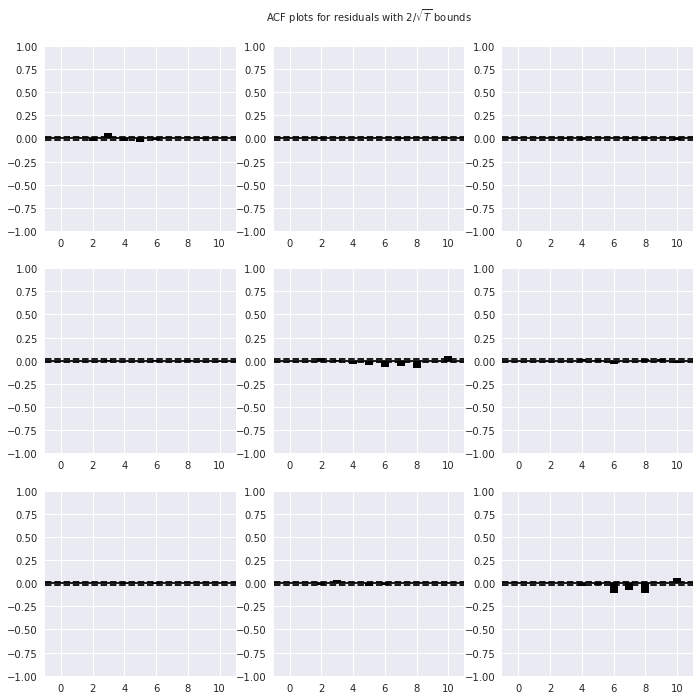

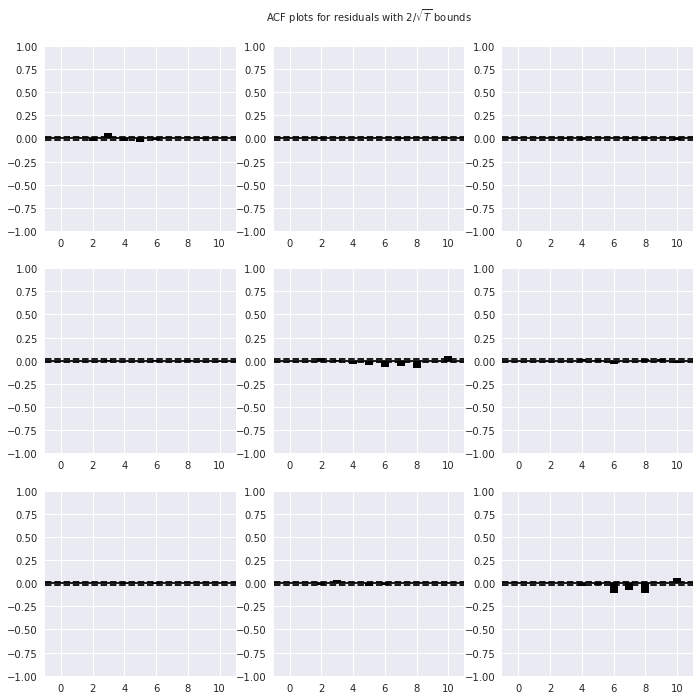

In [17]:
r_select.plot_acorr()

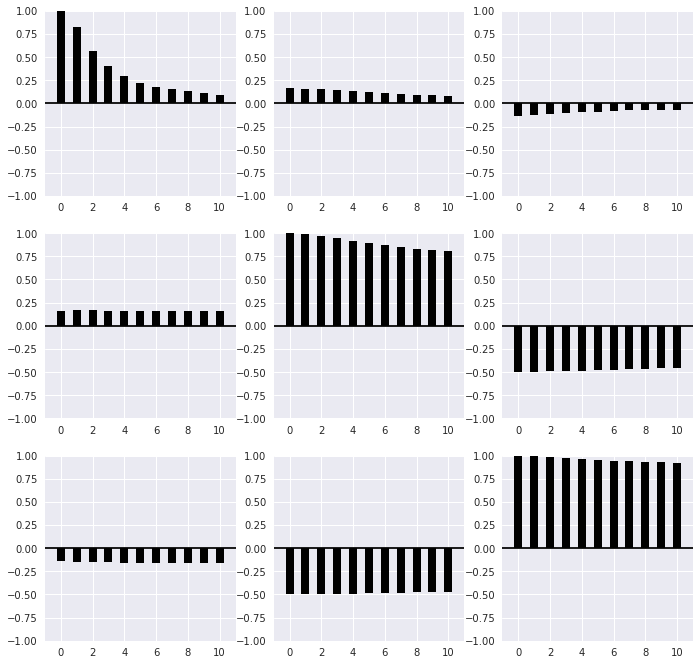

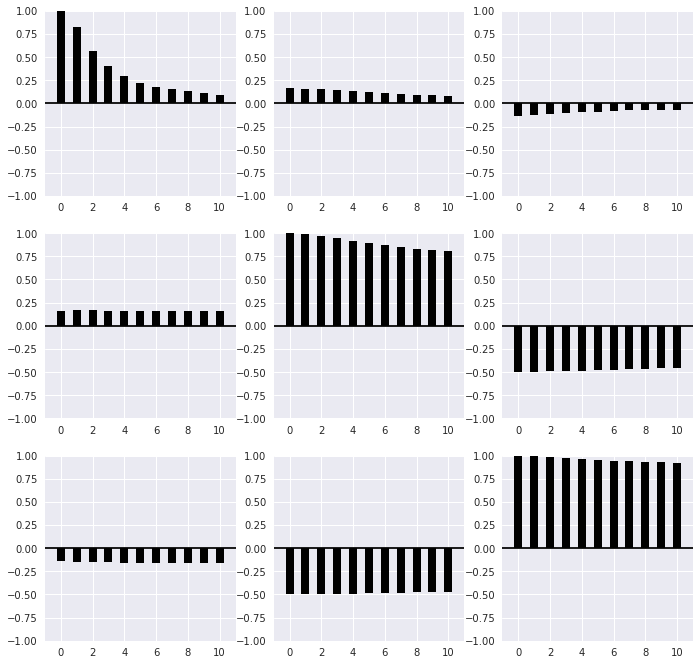

In [18]:
r_select.plot_sample_acorr()

In [20]:
col = rg_data.columns.tolist()

In [30]:
cause = result.test_causality(col[2], [col[1]], kind='f')

In [31]:
cause.summary()

Test statistic,Critical value,p-value,df
51.66,2.996,0.000,"(2, 43773)"
